# ПОКЕМОНЫ Асташкин ПИ18-2

In [65]:
import csv
import numpy  as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.naive_bayes import MultinomialNB
import sklearn as sk
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
%matplotlib inline

pokemon=pd.read_csv('pokemon.csv', sep=',', encoding='UTF-8')
combats=pd.read_csv('combats.csv', sep=',', encoding='UTF-8')
tests=pd.read_csv('tests.csv', sep=',', encoding='UTF-8')

## Обзор таблицы боев

In [2]:
combats.head()

,First_pokemon,Second_pokemon,Winner
0,266,298,298
1,702,701,701
2,191,668,668
3,237,683,683
4,151,231,151


	First_pokemon - первый покемон учавствующий в бою
    Second_pokemon - второй покемон учавствующий в бою
    winner - Победитель

In [3]:
combats.shape

(50000, 3)

Разделем таблицу по столбцам для дальнейшей работы.

In [4]:
y= []
com1 = combats['First_pokemon']
com2 = combats['Second_pokemon']
win =combats['Winner']
for i in range(len(win)):
    if win[i]==com1[i]:
        y.append(1)
    else:
        y.append(0)
com1 = pd.DataFrame(com1)
com2 = pd.DataFrame(com2)

Обзор таблицы покемонов

(array([26399.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 23601.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

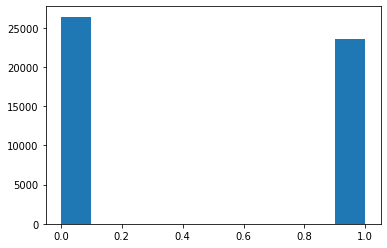

In [5]:
plt.hist(y)

In [6]:
pokemon.head()

,num,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,1,False
3,4,Mega Venusaur,Grass,Poison,80,100,123,122,120,80,1,False
4,5,Charmander,Fire,NaN,39,52,43,60,50,65,1,False


num - id покемона

Name - имя

Type 1 - основной тип покемона

Type 2 - второстепенный тип покемона

HP - кол-во жизней

Attack - сила физической атаки 

Defense - защита от физических атак

Sp.Atk - сила специальной атаки

Sp.Def - защита от специальных атак

Speed - скорость((порядок хода))

Generation -  поколение

Legendary - легендарный ли покемон

In [7]:
pokemon.shape

(800, 12)

In [8]:
pokemon.isnull().sum()

num             0
Name            1
Type 1          0
Type 2        386
HP              0
Attack          0
Defense         0
Sp. Atk         0
Sp. Def         0
Speed           0
Generation      0
Legendary       0
dtype: int64

In [9]:
pokemon['Type 2'] = [i if not pd.isna(i) else 'Nan' for i in pokemon['Type 2']]

избавимся от Nan значений во второстепенном типе, заменив на классификатор

In [10]:
types1 = pokemon['Type 1'].unique() # Формируем данные для графиков
coun1 = []
for i in types1:
    coun1.append(pokemon['Type 1'][pokemon['Type 1']==i].count())

types2 = pokemon['Type 2'].unique() 
coun2 = []
for i in types2:
    coun2.append(pokemon['Type 2'][pokemon['Type 2']==i].count())

gen=pokemon['Generation'].unique()
coun=[]
for i in gen:
    coun.append(pokemon['Generation'][pokemon['Generation']==i].count())

leg=pokemon['Legendary'].unique()
counleg=[]
for i in leg:
    counleg.append(pokemon['Legendary'][pokemon['Legendary']==i].count())


Распределение первостепеных типов


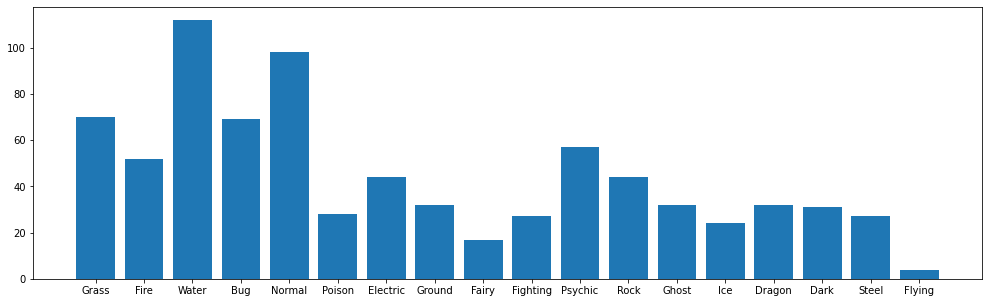

In [11]:
plt.figure(figsize=(17, 5))
plt.bar(types1,coun1)
print('Распределение первостепеных типов')

<BarContainer object of 19 artists>

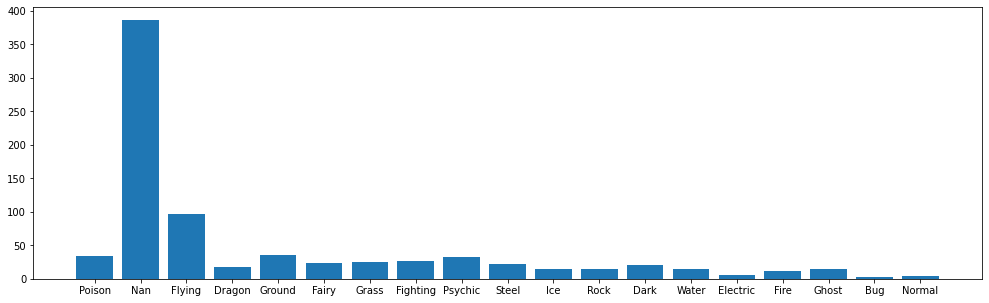

In [12]:
plt.figure(figsize=(17, 5))
plt.bar(types2,coun2)

РАспределение второстепенных типов

<BarContainer object of 6 artists>

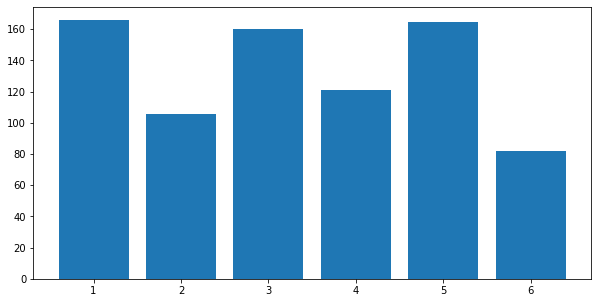

In [13]:
plt.figure(figsize=(10, 5))
plt.bar(gen,coun)

Распеределение покемонов по поколениям

<BarContainer object of 2 artists>

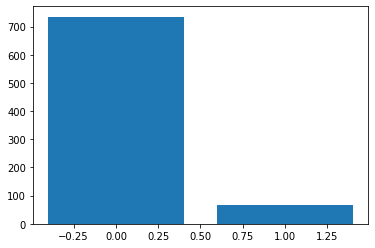

In [14]:
plt.bar(leg,counleg)

Распределение легендарных покемонов

In [15]:
corr = pokemon.corr()
corr.style.background_gradient(cmap='coolwarm')

,num,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
num,1.000000,0.097712,0.102664,0.094691,0.089199,0.085596,0.012181,0.983428,0.154336
HP,0.097712,1.000000,0.422386,0.239622,0.362380,0.378718,0.175952,0.058683,0.273620
Attack,0.102664,0.422386,1.000000,0.438687,0.396362,0.263990,0.381240,0.051451,0.345408
Defense,0.094691,0.239622,0.438687,1.000000,0.223549,0.510747,0.015227,0.042419,0.246377
Sp. Atk,0.089199,0.362380,0.396362,0.223549,1.000000,0.506121,0.473018,0.036437,0.448907
Sp. Def,0.085596,0.378718,0.263990,0.510747,0.506121,1.000000,0.259133,0.028486,0.363937
Speed,0.012181,0.175952,0.381240,0.015227,0.473018,0.259133,1.000000,-0.023121,0.326715
Generation,0.983428,0.058683,0.051451,0.042419,0.036437,0.028486,-0.023121,1.000000,0.079794
Legendary,0.154336,0.273620,0.345408,0.246377,0.448907,0.363937,0.326715,0.079794,1.000000


Высокие характеристики часто соответсвуют легендарным покемонам, Также сами характиристики редко сильно друг от друга отличаются

In [16]:
pokemon = pokemon.join(pd.get_dummies(pokemon['Type 1']),lsuffix='1')
pokemon = pokemon.join(pd.get_dummies(pokemon['Type 2']),lsuffix='1',rsuffix='2')
pokemon = pokemon.join(pd.get_dummies(pokemon['Generation']))

Преобразуем данные под классификатор

In [17]:
pokemon.head()

,num,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,...,Psychic2,Rock2,Steel2,Water2,1,2,3,4,5,6
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,...,0,0,0,0,1,0,0,0,0,0
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,...,0,0,0,0,1,0,0,0,0,0
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,...,0,0,0,0,1,0,0,0,0,0
3,4,Mega Venusaur,Grass,Poison,80,100,123,122,120,80,...,0,0,0,0,1,0,0,0,0,0
4,5,Charmander,Fire,Nan,39,52,43,60,50,65,...,0,0,0,0,1,0,0,0,0,0


In [18]:
pokemon = pokemon.drop(columns=['Name', 'Type 1','Type 2', 'Generation']) #избавимся от лишних данных

In [19]:
corr = pokemon.corr()
corr.style.background_gradient(cmap='coolwarm')

ПОБАЛОВАЛИСЬ

In [20]:
f1 = com1.merge(pokemon, left_on='First_pokemon', right_on='num', how='left')
f1 = f1.drop(columns=['First_pokemon','num'])
f1.head()

,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Legendary,Bug1,Dark1,Dragon1,...,Psychic2,Rock2,Steel2,Water2,1,2,3,4,5,6
0,50,64,50,45,50,41,False,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,91,90,72,90,129,108,True,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,55,40,85,80,105,40,False,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,40,40,40,70,40,20,False,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,70,60,125,115,70,55,False,0,0,0,...,0,0,0,1,1,0,0,0,0,0


Подготовим данные, соеденим данные о покемонах с 50000 таблицей

In [21]:
f2 = com2.merge(pokemon, left_on='Second_pokemon', right_on='num', how='left')
f2 = f2.drop(columns=['Second_pokemon','num'])
f2.head()

,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Legendary,Bug1,Dark1,Dragon1,...,Psychic2,Rock2,Steel2,Water2,1,2,3,4,5,6
0,70,70,40,60,40,60,False,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,91,129,90,72,90,108,True,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,75,75,75,125,95,40,False,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,77,120,90,60,90,48,False,0,0,1,...,0,0,0,0,0,0,0,0,1,0
4,20,10,230,10,230,5,False,1,0,0,...,0,1,0,0,0,1,0,0,0,0


In [22]:
x = f1.join(f2,lsuffix='1',rsuffix='2')
x.head()

,HP1,Attack1,Defense1,Sp. Atk1,Sp. Def1,Speed1,Legendary1,Bug11,Dark11,Dragon11,...,Psychic22,Rock22,Steel22,Water22,12,22,32,42,52,62
0,50,64,50,45,50,41,False,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,91,90,72,90,129,108,True,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,55,40,85,80,105,40,False,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,40,40,40,70,40,20,False,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,70,60,125,115,70,55,False,0,0,0,...,0,1,0,0,0,1,0,0,0,0


Соеденим все в едино, и получим итогой датасет. Не целевых данных

In [33]:
names = []
for i in x: 
    names.append(i)

In [68]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,random_state=True)

Используем классификатор RandomForest и обучим его

In [69]:
clf = RandomForestClassifier()
clf.fit(x_train, y_train)
print(clf.score(x_train, y_train))
print(clf.score(x_test, y_test))

1.0
0.9414


In [26]:
y_pred = clf.predict(x_test) # Мутим предсказания
from sklearn import metrics
mt = metrics.confusion_matrix(y_test, y_pred)
mt

array([[4966,  314],
       [ 285, 4435]], dtype=int64)

Text(0.5, 15.0, 'Предсказанные значения')

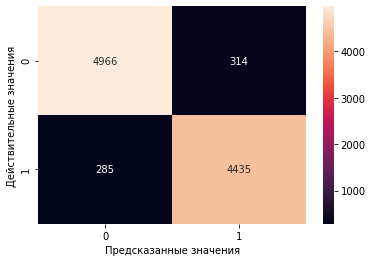

In [27]:
class_names = range(2)
fig, ax = plt.subplots()
ticks = np.arange(len(class_names))
plt.xticks(ticks, class_names)
plt.yticks(ticks, class_names)
sns.heatmap(pd.DataFrame(mt),annot=True,fmt="d")
plt.ylabel('Действительные значения')
plt.xlabel('Предсказанные значения')

In [28]:
print(f'Accuracy - {metrics.accuracy_score(y_test, y_pred)}')
print(f'Precision - {metrics.precision_score(y_test, y_pred)}')
print(f'Recall - {metrics.recall_score(y_test, y_pred) }')

Accuracy - 0.9401
Precision - 0.9338808170141082
Recall - 0.9396186440677966


# Посмотрим на фитуре импортанс

<BarContainer object of 100 artists>

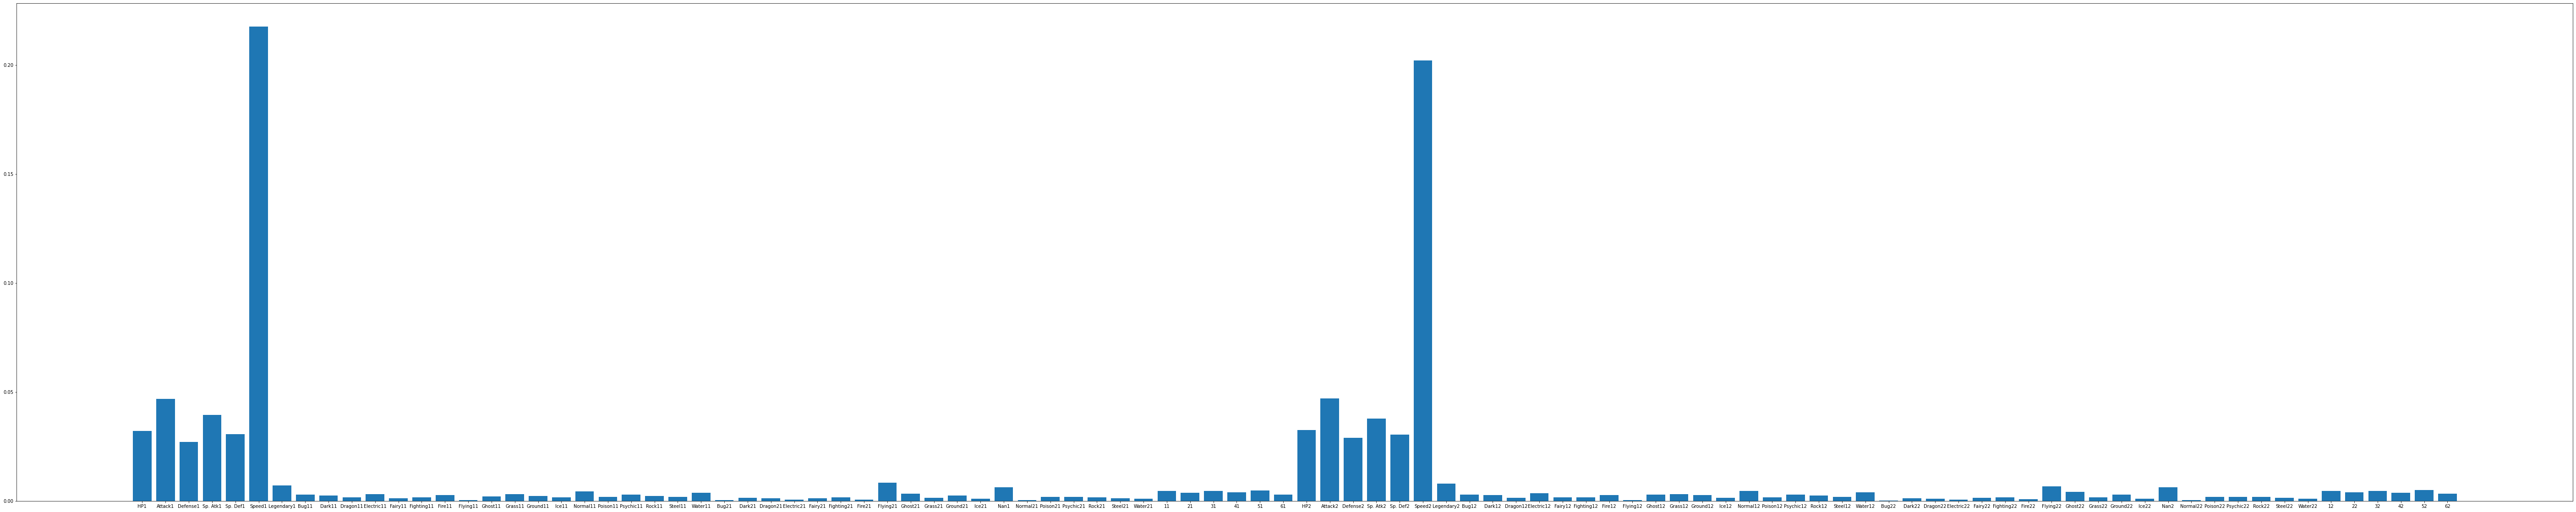

In [47]:
importance = clf.feature_importances_
importance
plt.figure(figsize=(100, 20))
plt.bar(names,importance)

Видим что самое большое значение имеют первые показатели наших покемонов
Посмотрим поближе.

<BarContainer object of 7 artists>

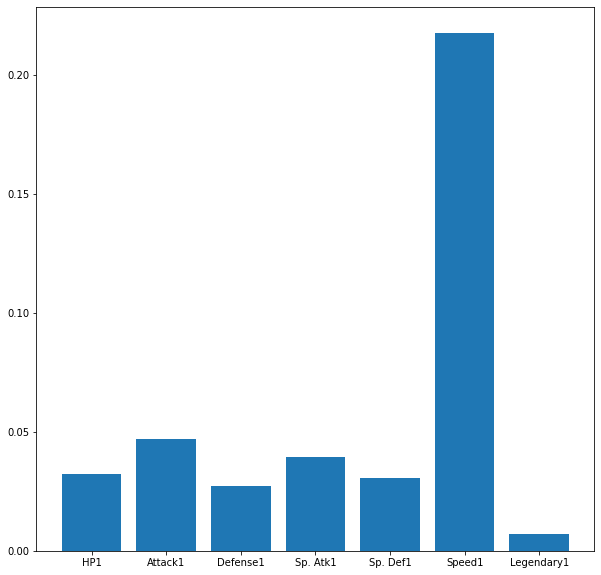

In [43]:

plt.figure(figsize=(10, 10))
plt.bar(names[0:7],importance[0:7])

Логично, что важными оказались именно характеристики покемонов. Однако для меня открытие: насколько важна скокрость покемонов. Видимо право первого удара очень часто решает, кто победит.

Сделаем тоже самое но без учете поколений.

In [46]:
pokemon=pd.read_csv('pokemon.csv', sep=',', encoding='UTF-8')
combats=pd.read_csv('combats.csv', sep=',', encoding='UTF-8')

pokemon['Type 2'] = [i if not pd.isna(i) else 'Nan' for i in pokemon['Type 2']]
pokemon = pokemon.join(pd.get_dummies(pokemon['Type 1']),lsuffix='1')
pokemon = pokemon.join(pd.get_dummies(pokemon['Type 2']),lsuffix='1',rsuffix='2')
pokemon = pokemon.drop(columns=['Name', 'Type 1','Type 2', 'Generation'])
f1 = com1.merge(pokemon, left_on='First_pokemon', right_on='num', how='left')
f1 = f1.drop(columns=['First_pokemon','num'])
f2 = com2.merge(pokemon, left_on='Second_pokemon', right_on='num', how='left')
f2 = f2.drop(columns=['Second_pokemon','num'])
x1 = f1.join(f2,lsuffix='1',rsuffix='2')
x1.head()

,HP1,Attack1,Defense1,Sp. Atk1,Sp. Def1,Speed1,Legendary1,Bug11,Dark11,Dragon11,...,Grass22,Ground22,Ice22,Nan2,Normal22,Poison22,Psychic22,Rock22,Steel22,Water22
0,50,64,50,45,50,41,False,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,91,90,72,90,129,108,True,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,55,40,85,80,105,40,False,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,40,40,40,70,40,20,False,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,70,60,125,115,70,55,False,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [47]:
clf1 = RandomForestClassifier()
clf1.fit(x_train, y_train)

RandomForestClassifier()

In [31]:
print(clf1.score(x_train, y_train))
print(clf1.score(x_test, y_test))

1.0
0.9401
0.98802


# Попробуем пройтись гридсерчером

In [66]:
rfreereg = RandomForestClassifier(n_jobs=-1)
param_grid = {
'n_estimators': [100, 150, 200, 250],
'max_depth': [2,3,4,5,6,7,8],
'min_samples_split': [3,5,7,9],
'max_features': ['auto', 'sqrt', 'log2']
}
rfreereg_grid_search = GridSearchCV(rfreereg, param_grid, cv=3, n_jobs=-1, verbose=True)
rfreereg_grid_search.fit(x_train, y_train)

print(rfreereg_grid_search.best_params_)

Fitting 3 folds for each of 336 candidates, totalling 1008 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 1008 out of 1008 | elapsed:  9.3min finished


{'max_depth': 8, 'max_features': 'sqrt', 'min_samples_split': 7, 'n_estimators': 150}


In [76]:
clf = RandomForestClassifier(max_depth=20,n_estimators=150, min_samples_split=7, max_features='sqrt')
clf.fit(x_train, y_train)
print(clf.score(x_train, y_train))
print(clf.score(x_test, y_test))

0.97645
0.9373


Особых улучшений мы не видим.

# Обучение без учителя

In [1]:
for i in range(1,15):
    pca = PCA(n_components=i)
    new_features = StandardScaler().fit_transform(x)
    new_features = pca.fit_transform(new_features)

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
    best_RMSE = 999999
    best_r2 = 0

    rfreereg = RandomForestClassifier(n_estimators=150, min_samples_split=7, max_features='sqrt')

    rfreereg.fit(x_train, y_train)
    y_pred_test = rfreereg.predict(x_test)
    RMSE = np.sqrt(mean_squared_error(y_test, y_pred_test))

    r2 = r2_score(y_test, y_pred_test)
    if best_RMSE > RMSE:
        best_RMSE = RMSE
    if best_r2 < r2:
        best_r2 = r2
    print("RMSE: {} r2: {} PCA_num: {}".format(best_RMSE, best_r2, i))

NameError: name 'PCA' is not defined